Populating the interactive namespace from numpy and matplotlib
frequency of categorical variables
Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64
frequency of categorical variables
Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64
frequency of categorical variables
Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64
frequency of categorical variables
Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tie

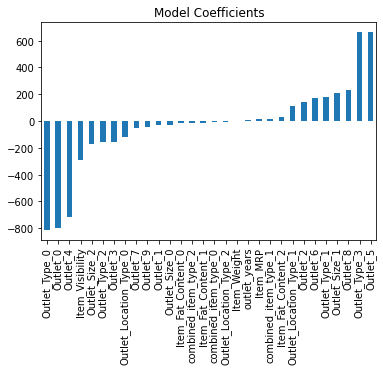

In [13]:
import pandas as pd
import seaborn as sns 
import numpy as np 
import matplotlib.pylab as plt


# for plotting graphs in notebook 

%pylab inline 

train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

train.head()

#combining train  and test dataframes for data cleaning 
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train,test],ignore_index=True)

data.Item_Identifier.value_counts() #1559 items 

train.isnull().sum()


data.isnull().sum() #null in test is 5681

data.describe()

#Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']

categorical_columns # all are not required 

categorical_columns = [x for x in categorical_columns if x not in ["Item_Identifier","Outlet_Identifier","source"]]

categorical_columns

for col in categorical_columns:
    print ("frequency of categorical variables")
    print(col)
    print(data[col].value_counts())



item_avg_weight = data.pivot_table(values= 'Item_Weight', index='Item_Identifier')


item_avg_weight.head()

item_avg_weight.Item_Weight['DRA12'] #just a check

null_item_weight = data['Item_Weight'].isnull()

null_item_weight.head()

data.loc[null_item_weight,'Item_Weight'] = data.loc[null_item_weight,'Item_Identifier'].apply(lambda x: item_avg_weight.Item_Weight[x])

data.isnull().sum() # item_weight filled

#outlet size is having missing values 
# impute the values from its mode values 
from scipy.stats import mode

outlet_size_mode = data.dropna(subset=['Outlet_Size']).pivot_table(values='Outlet_Size',columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]))

outlet_size_mode

#missing values of Outlet size 
null_outlet_size = data['Outlet_Size'].isnull()



data.loc[null_outlet_size,'Outlet_Size'] = data.loc[null_outlet_size,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
# filling missing values of Outlet size with mode value
#mode value is related to outlet type 



data.isnull().sum()



#Feature engineering 
# Outlet type 
#combining two or morw outlet type 

data.pivot_table(values='Item_Outlet_Sales',index='Outlet_Type')
# should not combine any outlet type b/c of significant difference b/w mean values of sales

data.isnull().sum()

# Item visibility 
# values woth zero makes no sense 
# replace it with mean value according to Item identifier 

avg_visb = data.pivot_table(values='Item_Visibility',index='Item_Identifier')


avg_visb

zero_value_visb = (data['Item_Visibility']==0)

zero_value_visb

data.loc[zero_value_visb,'Item_Visibility'] = data.loc[zero_value_visb,'Item_Identifier'].apply(lambda x:avg_visb.Item_Visibility[x])

#zeros of Item_Visibility is reaplced from mean of value of particular Item_Identifier 

data.Item_Type.unique()

#create a new variable
#Now Item_type are of 16 type we can convert them into 3 broad categories 
# Each Item_type had Item_Identifier with start as FD or DR or NC 
# example item_type = Soft drink check Item Identifier it always start with DR

data['combined_item_type'] = data['Item_Identifier'].apply(lambda x:x[0:2])

data['combined_item_type'] = data['combined_item_type'].map({'FD':'Food',
                                                         'DR':'Drinks',
                                                         'NC':'Non-consumables'})

data.combined_item_type.value_counts()

#year of sales variable is important 
#create a new variable of number of years 

data['outlet_years'] = 2013 - data.Outlet_Establishment_Year

#Item_Fat_content has ambiguity 

data.Item_Fat_Content.unique()

data.Item_Fat_Content = data.Item_Fat_Content.map({'Low Fat':'Low Fat','Regular':'Regular','low fat':'Low Fat','LF':'Low Fat','reg':'Regular'})

data.Item_Fat_Content.value_counts()

#But what about non consumable in combined_item_type 
# non consumable cannot have fat content 
#separte them as non edible in item fat content

data.loc[data.combined_item_type=='Non-consumables','Item_Fat_Content']='Non-edible'

data.Item_Fat_Content.value_counts()

#dummy variables creation 
#converting all the categorical variables into numerical varialbles
#sklearn preprocessing lable encoder is used

data.Outlet_Identifier.unique()

#creat a new variable oullet same as outlet Identifier 
#We will not remove outlet identifier b/c it is required in file submission 
# so dummy of new variable outlet is produced 

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#create new variable outlet 
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
#le.fit_transform convert it into numerical 


type(data.Outlet)

convert_var = [x for x in data.dtypes.index if data.dtypes[x]=='object']

convert_var

var = ['Item_Fat_Content','Outlet_Location_Type','combined_item_type','Outlet_Size','Outlet_Type','Outlet']

for x in var:
    data[x]=le.fit_transform(data[x])
    #all the columns in var are converted in numericals

# now we can perform dummy creation 


data = pd.get_dummies(data,columns=var)

data.dtypes

data.head()

#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']

#Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
from sklearn import model_selection, metrics
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = model_selection.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring=None)
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\nModel Report")
    print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)



from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train.columns if x not in [target]+IDcol]
# print predictors
alg1 = LinearRegression(normalize=True)
modelfit(alg1, train, test, predictors, target, IDcol, 'alg1.csv')
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

coef1

#We can see this is better than baseline model.
#But if you notice the coefficients, they are very large in magnitude which signifies overfitting.

#Ridge regression 
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg2 = Ridge(alpha=0.05,normalize=True)
modelfit(alg2, train, test, predictors, target, IDcol, 'alg2.csv')
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')